In [1]:
import psycopg2 as pg2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from Player_rank import Player_ranker
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
'''
Here we're loading in all of the traditional Fantasy basketball stats into SQL, using window function to get a ranking by minutes

'''

"\nHere we're loading in all of the traditional Fantasy basketball stats into SQL, using window function to get a ranking by minutes\n\n"

In [3]:
'''IF you have open connections run the following in the psql command prompt:

SELECT pg_terminate_backend(pid) FROM pg_stat_activity WHERE datname = 'nba_capstone';

'''

"IF you have open connections run the following in the psql command prompt:\n\nSELECT pg_terminate_backend(pid) FROM pg_stat_activity WHERE datname = 'nba_capstone';\n\n"

In [4]:
conn = pg2.connect(dbname = 'postgres',host='localhost')


In [5]:
conn.autocommit = True

In [6]:
cur = conn.cursor()


In [7]:
'''Note for some reason you can not access the database if it is not all lowercase'''

cur.execute('DROP DATABASE IF EXISTS nba_capstone;')  # Makes sure there is not already a class_example database and removes is if there is
cur.execute('CREATE DATABASE nba_capstone;')



In [8]:
cur.close()
conn.close()

In [9]:
conn = pg2.connect(dbname = 'nba_capstone',host='localhost')
conn.autocommit = True

In [10]:
cur = conn.cursor()


In [11]:
query = '''
        CREATE TABLE NBA_stats (
            Season integer, 
            Player varchar(50), 
            Pos varchar(10),
            Age int,
            Tm varchar(15),
            G int,
            GS int,
            MP float,
            FG float,
            FGA float,
            FG_Percentage float,
            Threes_Made float,
            Threes_Attempted float,
            Three_Percentage float,
            Twos_Made float,
            Twos_Attempted float,
            Twos_Percentage float,
            eff_FG_Percentage float,
            FTM float,
            FTA float,
            FT_Percentage float,
            ORB float,
            DRB float,
            Rebounds float,
            AST float,
            STL float,
            BLK float,
            TOV float,
            Fouls float,
            Points float
        );
        '''

cur.execute(query)

In [12]:
# import os
# current_directory_path = os.getcwd()
# current_directory_path

query = '''
        COPY NBA_stats 
        FROM '/Users/rcheer/Desktop/Galvanize/Capstone/Fantasy-Basketball-Capstone-Project/NBA stats.csv' 
        DELIMITER ',' 
        CSV HEADER;
        '''



cur.execute(query)

In [13]:
query = '''
        CREATE TABLE nba_advanced (
            Season integer, 
            Player varchar(50), 
            Pos varchar(10),
            Age int,
            Tm varchar(15),
            G int,
            total_MP float,
            PER float,
            True_Shooting float,
            Three_Attempt_Rate float,
            FT_rate float,
            ORB_Percentage float,
            DRB_Percentage float,
            Rebound_Percentage float,
            Assist_Percentage float,
            Steal_Percentage float,
            Block_Percentage float,
            Turnover_Percentage float,
            Usage_Percentage float,
            Offensive_WinShares float,
            Defensive_WinShares float,
            WinShares float,
            WinShares_Per48 float,
            Offensive_BoxPlusMinus float,
            Defensive_BoxPlusMinus float,
            BoxPlusMinus float,
            Value_overReplacement float
        );
        '''

cur.execute(query)

In [14]:
query = '''
        COPY nba_advanced 
        FROM '/Users/rcheer/Desktop/Galvanize/Capstone/Fantasy-Basketball-Capstone-Project/NBA Advanced.csv' 
        DELIMITER ',' 
        CSV HEADER;
        '''



cur.execute(query)

In [15]:
'''
save for later
d.points,d.rebounds,d.ast,d.stl,d.blk,d.tov,d.fg_percentage,d.FT_percentage
'''


query1 = '''
            update nba_stats set Tm = 'NOP' where Tm = 'NOH';
            update nba_advanced set Tm = 'NOP' where Tm = 'NOH';
            update nba_stats set Tm = 'CHA' where Tm = 'CHO';
            update nba_advanced set Tm = 'CHA' where Tm = 'CHO';
            
            DROP TABLE IF EXISTS players;
            CREATE TABLE players AS
            select season,player,max(G) as Games from NBA_stats where Tm!='TOT' group by season,player;
            
            DROP TABLE IF EXISTS y_predictions;
            CREATE TABLE y_predictions AS
            select d.season,d.player,d.pos,d.age,MAX(case when p.player is not null then d.Tm else NULL end) as StartingTeam,SUM(G) as Games,SUM(GS) as GS,
            max(MP) as minutes
            from NBA_stats d
            left join players p
                on d.season = p.season
                and d.player = p.player
                and d.G = p.Games
            where d.Tm!='TOT'
            group by d.season,d.player,d.pos,d.age;
            
            update y_predictions set StartingTeam = 'NOP' where startingTeam = 'NOH';
            update y_predictions set StartingTeam = 'CHA' where startingTeam = 'CHO';
            
            DROP TABLE IF EXISTS rank_by_minutes;
            CREATE TABLE rank_by_minutes AS
            select y.*,n.points,n.rebounds,n.ast,n.stl,n.blk,n.tov,n.threes_made,n.fg,n.fga,n.ftm,n.fta,
            case when cast(y.GS as float)/y.Games >0.6 then 1 else 0 end as starter,
            row_number() over(partition by n.season order by MP*G desc) as min_rank from NBA_stats n
            inner join y_predictions y
                ON n.player = y.player
                and n.season = y.season
                and n.Tm=y.startingTeam;
            
            select * from rank_by_minutes        
                
        '''
cur.execute(query1)
data = cur.fetchall()
df = pd.DataFrame(np.array(data))
df.columns = ['season','player','position','age','team','gamesPlayed','gamesStarted','minutes'
              ,'points','rebounds','assists','steals','blocks','turnovers','threes_made','FGM','FGA','FTM','FTA','starter','min_rank']


In [16]:
df['min_rank']=pd.to_numeric(df['min_rank'])
df['points']=pd.to_numeric(df['points'])
df['rebounds']=pd.to_numeric(df['rebounds'])
df['assists']=pd.to_numeric(df['assists'])
df['steals']=pd.to_numeric(df['steals'])
df['blocks']=pd.to_numeric(df['blocks'])
df['turnovers']=pd.to_numeric(df['turnovers'])
df['threes_made']=pd.to_numeric(df['threes_made'])
df['FGM']=pd.to_numeric(df['FGM'])
df['FGA']=pd.to_numeric(df['FGA'])
df['FTM']=pd.to_numeric(df['FTM'])
df['FTA']=pd.to_numeric(df['FTA'])
df['gamesPlayed']=pd.to_numeric(df['gamesPlayed'])
df['gamesStarted']=pd.to_numeric(df['gamesStarted'])
df['minutes']=pd.to_numeric(df['minutes'])
df['age']=pd.to_numeric(df['age'])
df['season']=pd.to_numeric(df['season'])


In [17]:
test = Player_ranker(df)
test.get_category_dist()
test.cat_mean

,season,mean_points,mean_rebounds,mean_assists,mean_steals,mean_blocks,mean_turnovers,mean_threes_made,mean_fgm,mean_fga,mean_ftm,mean_fta
0,2008,13.3005,5.1235,2.7870,0.9150,0.5690,1.7035,0.8780,4.9095,10.5850,2.5990,3.3115
1,2009,12.9850,5.1080,2.8490,0.9120,0.5600,1.6965,0.8265,4.8530,10.4370,2.4600,3.1825
2,2010,12.9225,5.0185,2.8135,0.9085,0.5685,1.6790,0.8380,4.7955,10.3525,2.4955,3.2005
3,2011,12.1830,4.8915,2.6840,0.9225,0.5725,1.6805,0.8030,4.5925,10.1180,2.1955,2.8590
4,2012,12.5550,5.0520,2.8840,0.9585,0.6125,1.7410,0.8800,4.7285,10.3275,2.2150,2.8920
5,2013,13.0510,5.1265,2.8310,0.9505,0.5420,1.7375,0.9715,4.8545,10.5425,2.3790,3.1020
6,2014,12.3805,4.9890,2.7145,0.9230,0.5390,1.6315,0.9600,4.6260,10.1940,2.1725,2.8505
7,2015,12.8715,5.1935,2.7720,0.9530,0.5900,1.6785,1.0530,4.7645,10.4595,2.2840,2.9900
8,2016,13.3550,5.0420,2.8950,0.9230,0.5340,1.6195,1.2170,4.8980,10.6355,2.3385,2.9850
9,2017,13.2915,5.0950,2.9355,0.9240,0.5585,1.6825,1.3200,4.9175,10.6135,2.1395,2.7465


In [18]:
test.assign_values()

In [19]:
value_copy = test.value.copy()

In [20]:
value_copy.head()

,season,player,value_tot,value_points,value_rebounds,value_assists,value_blocks,value_steals,value_turnovers,value_threes,value_fg,value_ft
0,2008,Andre Iguodala,1.569149,1.022902,0.233549,1.209232,-0.313073,1.720216,-1.392654,0.164932,0.201353,-1.277308
1,2008,Joe Johnson,2.248938,1.506499,-0.293101,1.449827,-0.683573,0.464584,-1.113145,1.381647,-1.036752,0.572951
2,2008,O.J. Mayo,0.491912,0.967102,-0.536170,0.198732,-0.683573,0.464584,-1.532409,1.246456,-0.633993,1.001183
3,2008,Antawn Jamison,3.459954,1.655298,1.529918,-0.426816,-0.498323,0.715710,0.284401,0.705694,0.083254,-0.589183
4,2008,Raymond Felton,-0.135656,0.167306,-0.536170,1.882899,-0.313073,1.469090,-1.532409,-0.240639,-1.364914,0.332253


In [21]:
#copy value data back into SQL
engine = create_engine("postgresql://@localhost/nba_capstone")

value_copy.to_sql(name='value', con=engine, if_exists = 'replace', index=False)


In [22]:
query = '''
        DROP TABLE IF EXISTS player_value;
        CREATE TABLE player_value AS
        select ROW_NUMBER() OVER(PARTITION BY season ORDER BY value_tot DESC),* from value;
        
        DROP TABLE IF EXISTS value;
        
        select * from player_value;
        
        '''


cur.execute(query)
ranking_data = cur.fetchall()
df_2 = pd.DataFrame(np.array(ranking_data))
cols_value = ['playerrank']
for item in (list(value_copy.columns)):
    cols_value.append(item)
cols_value
df_2.columns=cols_value

In [23]:
for i in df_2.columns:
    if i!='player':
        df_2[i]=pd.to_numeric(df_2[i])



In [24]:
for i in df_2.columns:
    if i!='player':
        df_2[i]=pd.to_numeric(df_2[i])

In [25]:
df_2.head()

,playerrank,season,player,value_tot,value_points,value_rebounds,value_assists,value_blocks,value_steals,value_turnovers,value_threes,value_fg,value_ft
0,1,2008,Chris Paul,10.649584,1.766898,0.152526,3.952019,-0.868823,4.733733,-1.811918,-0.105449,1.195183,1.635414
1,2,2008,LeBron James,8.708530,2.808492,1.003268,2.123494,0.983678,1.971343,-1.811918,0.976075,0.888138,-0.234041
2,3,2008,Dwyane Wade,8.419529,3.143291,-0.050032,2.267852,1.354178,3.226975,-2.370936,0.300123,1.126183,-0.578103
3,4,2008,Danny Granger,6.463654,2.324895,-0.009520,-0.041864,1.539428,0.213457,-1.113145,2.463170,-0.678128,1.765360
4,5,2008,Dirk Nowitzki,6.094625,2.343495,1.327360,-0.186221,0.427928,-0.288795,-0.274618,-0.105449,0.611555,2.239370


In [26]:
df_2[df_2['season']==2017].sort_values(by='playerrank', ascending=True)

,playerrank,season,player,value_tot,value_points,value_rebounds,value_assists,value_blocks,value_steals,value_turnovers,value_threes,value_fg,value_ft
4219,1,2017,Anthony Davis,13.069292,2.728406,2.327843,-0.323373,4.382346,1.403769,-0.642579,-0.719758,2.572502,1.340136
4220,2,2017,Stephen Curry,10.977767,2.415188,0.001938,1.610250,-0.769567,1.647478,-1.635937,3.343394,1.073741,3.291282
4221,3,2017,Kevin Durant,10.555627,2.415188,0.660945,1.254056,2.665042,-0.545910,-1.635937,1.369863,1.809299,2.563082
4222,4,2017,James Harden,10.522310,3.152171,0.118234,2.984140,0.303748,2.134898,-3.374314,2.762944,-0.589500,3.029989
4223,5,2017,Karl-Anthony Towns,9.046572,1.475533,2.793024,-0.272488,1.806390,-0.302200,-0.270069,0.208962,2.213129,1.394291
4224,6,2017,LeBron James,8.050018,2.617858,1.358716,3.136795,0.733074,1.160059,-3.125975,0.557232,2.935558,-1.323300
4225,7,2017,Giannis Antetokounmpo,7.982516,2.507311,1.901427,0.948747,1.806390,1.403769,-1.635937,-0.835849,2.328774,-0.442116
4226,8,2017,Damian Lillard,7.758411,2.507311,-0.230652,1.864674,-0.340241,0.428929,-1.387598,2.066403,-0.920536,3.770119
4227,9,2017,Chris Paul,7.259998,0.978069,0.118234,2.526177,-0.769567,1.891188,-0.642579,1.369863,-0.176916,1.965529
4228,10,2017,Jimmy Butler,7.194467,1.641355,0.079468,0.999632,-0.340241,2.622318,-0.145900,-0.139308,0.324360,2.152782


In [25]:
''' Creating all teammate based changes
'''



query = '''
        DROP TABLE IF EXISTS adv_top10min;
        CREATE TEMPORARY TABLE adv_top10min as 
        select a.*,usage_percentage*total_MP/G as usage_withMins,row_number() over(partition by a.season,tm order by usage_percentage*total_MP/G desc) as usage_rank
        from(select *,row_number() over(partition by season,tm order by total_MP desc) as min_rank from nba_advanced) a
        inner join y_predictions y
                ON a.player = y.player
                and a.season = y.season
                and a.Tm=y.startingTeam
        where min_rank<=10;
        
        DROP TABLE IF EXISTS Change_Teams;
        CREATE TABLE Change_Teams AS
        select na.tm as old_team,na2.tm as new_team,na2.player,na2.pos,p.season,na.usage_withMins,
        n.points,n.rebounds,n.ast,n.threes_made,na.usage_rank 
        from player_value p
        inner join adv_top10min na
            on p.player = na.player
            and p.season = na.season+1
        inner join adv_top10min na2
            on na2.player = na.player
            and na2.season = p.season
            and na2.tm != na.tm
        inner join rank_by_minutes n
            ON N.player = na.player
            and n.season = na.season;
        
        
        
        DROP TABLE IF EXISTS incoming_by_team;
        CREATE TABLE incoming_by_team AS
        select new_team,season,SUM(case when usage_withmins >1000 then 1 else 0 end) as high_usageplayer_added,
        SUM(usage_withmins) as usagemin_added, MAX(usage_withmins) as max_usageadded,
        SUM(points) as points_added, MAX(points) as max_pointsadded,SUM(rebounds) as rebounds_added,
        MAX(rebounds) as max_reboundsadded, SUM(ast) as ast_added, MAX(ast) as max_astadded,
        SUM(threes_made) as threes_added, MAX(threes_made) as max_threesadded 
        from change_teams
        group by new_team,season;
        
        DROP TABLE IF EXISTS outgoing_by_team;
        CREATE TABLE outgoing_by_team AS
        select old_team,season,SUM(case when usage_withmins >1000 then 1 else 0 end) as high_usageplayer_dropped,
        SUM(usage_withmins) as usagemin_dropped, MAX(usage_withmins) as max_usagedropped,
        SUM(points) as points_dropped, MAX(points) as max_pointsdropped,SUM(rebounds) as rebounds_dropped,
        MAX(rebounds) as max_reboundsdropped, SUM(ast) as ast_dropped, MAX(ast) as max_astdropped,
        SUM(threes_made) as threes_dropped, MAX(threes_made) as max_threesdropped
        from change_teams
        group by old_team,season;
        
        DROP TABLE IF EXISTS Team_Changes;
        CREATE TABLE Team_Changes AS
        select c.new_team as team, c.season,c.high_usageplayer_added,o.usagemin_dropped-c.usagemin_added as usagemin_opened,
        c.max_usageadded,o.high_usageplayer_dropped,o.max_usagedropped,
        o.points_dropped-c.points_added as points_opened,max_pointsdropped,max_pointsadded,
        o.rebounds_dropped-c.rebounds_added as rebounds_opened,max_reboundsdropped,max_reboundsadded,
        o.ast_dropped-c.ast_added as ast_opened,max_astdropped,max_astadded,
        o.threes_dropped-c.threes_added as threes_opened,max_threesdropped,max_threesadded
        from incoming_by_team c
        inner join outgoing_by_team o
            ON o.old_team = c.new_team
            and o.season = c.season;
            
        DROP TABLE IF EXISTS Team_maxes;
        CREATE TABLE Team_maxes AS
        select R.season,R.startingTeam,MAX(R2.points) as pts, max(r2.rebounds) as reb, max(r2.ast) as ast,
        MAX(R2.Tov) as TO,MAX(r2.FGA) as shot_attempts, cast(NULL as float) as max_usage 
        from rank_by_minutes R
        inner join rank_by_minutes R2
            ON R2.startingTeam = R.startingTeam
            and R2.season+1 = R.season
        group by R.season,R.startingTeam;
        
        
        update Team_maxes T
        set max_usage = usage
        from
        (select T.season,T.startingTeam,T.pts,t.reb,t.ast,t.TO,MAX(a.usage_percentage) as usage from Team_maxes T
        inner join adv_top10min a
            ON a.season+1 = t.season
            and a.tm = t.startingteam
        group by T.season,T.startingTeam,T.pts,t.reb,t.ast,t.TO) A
        WHERE A.season = T.season and  A.startingTeam = T.startingTeam;
        
        
        
        '''


cur.execute(query)

In [432]:
''' Get player based data
'''



query = '''
        DROP TABLE IF EXISTS player_stats;
        CREATE TABLE player_stats AS
        select r.*,r2.starter as starter_ly,r3.points-r2.points as change_points_ly,r2.points as points_ly
        ,r3.rebounds-r2.rebounds as change_reb_ly, r2.rebounds as rebounds_ly,
        r3.ast-r2.ast as change_ast_ly, r2.ast as ast_ly,r3.stl-r2.stl as change_stl_ly,r2.stl as stl_ly,
        r3.blk-r2.blk as change_blk_ly, r2.blk as blk_ly,r3.tov-r2.tov as change_tov_ly,r2.tov as tov_ly,
        r2.threes_made as threes_ly,r3.threes_made-r2.threes_made as change_threes
        from rank_by_minutes r
        left join rank_by_minutes r2
            on r.player = r2.player
            and r.season = r2.season+1
        left join rank_by_minutes r3
            ON r3.player = r2.player
            and r3.season+1 = r2.season;
        
        DROP TABLE IF EXISTS player_advstats;
        CREATE TABLE player_advstats AS
        select y.player,y.season,y.startingteam,a.per as per_ly, a2.per-a.per as change_per,a.three_attempt_rate as threeAR_ly,
        a2.three_attempt_rate-a.three_attempt_rate as change_3AR, a.rebound_percentage as reb_perc_ly, a2.rebound_percentage-a.rebound_percentage as change_reb_perc
        ,a.assist_percentage as ast_perc_ly, a2.assist_percentage-a.assist_percentage as change_assist_perc
        ,a.steal_percentage as stl_perc_ly, a2.steal_percentage-a.steal_percentage as change_stl_perc_ly
        ,a.block_percentage as blk_perc_ly, a2.block_percentage-a.block_percentage as change_blk_perc_ly
        ,a.turnover_percentage as TO_perc_ly, a2.turnover_percentage-a.turnover_percentage as change_turnover_perc_ly,
        rank() over(partition by y.season,y.startingTeam order by a.usage_percentage) as usagerank,
        rank() over(partition by y.season,a.tm order by a.usage_percentage) as usagerank_ly,
        a.offensive_winshares,
        a.defensive_winshares,a.winshares,a.winshares_per48,a.offensive_boxplusminus,a.defensive_boxplusminus,
        a.boxplusminus,a.value_overreplacement        
        from y_predictions y
        left join nba_advanced a
            ON a.player = y.player
            and a.season+1 = y.season
        left join nba_advanced a2
            ON a2.player = a.player
            and a2.season+1 = a.season;
    
        
        DROP TABLE IF EXISTS player_careerstats;
        CREATE TABLE player_careerstats AS
        select r.player,r.season,SUM(case when r2.player is not null then 1 else 0 end) as YearsPro, avg(r2.points) as career_points
        ,avg(r2.rebounds) as career_rebounds,avg(r2.ast) as career_ast, avg(r2.stl) as career_stl, avg(r2.blk) as career_blk
        ,avg(r2.tov) as career_TO, avg(r2.threes_made) as career_threesmade,avg(r2.ftm) as career_ftm,avg(r2.fta) as career_fta
        ,avg(r2.fga) as career_fga, avg(r2.fg) as career_fgm
        from rank_by_minutes r
        inner join rank_by_minutes r2
            ON r.player = r2.player
            and r.season > r2.season
        group by r.player,r.season;
       
        '''


cur.execute(query)


In [32]:
 query= '''
        
        DROP TABLE IF EXISTS points_pred;
        CREATE TABLE points_pred(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        points float, -- these come from player_stats
        points_ly float,
        change_points_ly float,
        starter_change int,
        C_PF int,
        PG int,
        SG_SF int,
        
         -- these come from team_changes
        high_usageplayer_added int,
        usagemin_opened float,
        maxusage_added float,
        high_usageplayer_dropped int,
        points_opened float,
        max_pointsdropped float,
        max_pointsadded float,
        
        three_ar_ly float, -- from player_advstats
        change_3ar float,
        per_ly float,
        change_per float,
        usagerank float,
        usagerank_ly float,
        offensive_winshares float,
        offensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        career_points float,
        yearspro int
        );
        
        INSERT INTO points_pred(season,player,age,team,points,points_ly,change_points_ly,starter_change,C_PF,PG,SG_SF)
        SELECT season,player,age,startingteam,points,points_ly,change_points_ly,starter-starter_ly,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end from player_stats;
        
        update points_pred pp
        set high_usageplayer_added = tc.high_usageplayer_added,usagemin_opened=tc.usagemin_opened,
        maxusage_added=tc.max_usageadded,high_usageplayer_dropped=tc.high_usageplayer_dropped,points_opened=tc.points_opened,
        max_pointsdropped=tc.max_pointsdropped,max_pointsadded=tc.max_pointsadded
        from team_changes tc
        where tc.team = pp.team and pp.season=tc.season;
        
        update points_pred pp
        set three_ar_ly = pa.threear_ly,change_3ar=pa.change_3ar,per_ly=pa.per_ly,change_per=pa.change_per,
        usagerank=pa.usagerank,usagerank_ly=pa.usagerank_ly,offensive_winshares=pa.offensive_winshares,
        offensive_boxplusminus=pa.offensive_boxplusminus,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where pp.player = pa.player and pp.season = pa.season and pp.team = pa.startingteam;
        
        update points_pred pp
        set career_points = pc.career_points, yearspro = pc.yearspro
        from player_careerstats pc
        where pp.player = pc.player and pp.season = pc.season;
        
        
        select * from points_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
points_df = pd.DataFrame(np.array(data))
points_df.columns = ['season','player','age','team','points','points_ly','change_points_ly','starter_change','C_PF','PG','SG_SF','high_usageplayer_added','usagemin_opened','maxusage_added','high_usageplayer_dropped','points_opened','max_pointsdropped',
                    'max_pointsadded','three_ar_ly','change_3ar','per_ly','change_per','usagerank','usagerank_ly','offensive_winshares','offensive_boxplusminus','boxplusminus','value_overreplacement','career_points','yearspro']

In [33]:
rookies = points_df[points_df['points_ly'].isna()]
rookies.sort_values(by='points',ascending=False)

In [35]:
players = points_df[points_df['points_ly'].notna()]
for i in players.columns:
    if i not in(['player','team']):
        players[i]=pd.to_numeric(players[i])
players = players.fillna(0)

In [39]:
y = players[players['season']!=2017]['points']
X = players[players['season']!=2017].drop(['points','player','season','team'],axis=1)

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV

In [36]:
cur.close()
conn.close

<function connection.close>

In [44]:

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [39]:
r2_lr = np.mean(cross_val_score(LinearRegression(),X_train,y_train,cv=10,n_jobs=-1))
print('Linear Regression error: {}'.format(r2_lr))

r2_gb = np.mean(cross_val_score(GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5),X_train,y_train,cv=5,n_jobs=-1))
print('GradientBoost error: {}'.format(r2_gb))

r2_rf = np.mean(cross_val_score(RandomForestRegressor(n_estimators=1000,max_depth = 3,max_features=0.5),X_train,y_train,cv=5,n_jobs=-1))
print('RandomForest error: {}'.format(r2_rf))

Linear Regression error: 0.7706184121337402
GradientBoost error: 0.7695143834691159
RandomForest error: 0.7068402746139153


In [65]:
parameters = {'learning_rate':[0.01,0.05,0.1], 'n_estimators':[1000,2000],'max_depth':[3,5,7,10],'max_features':[0.1,0.3,0.5]}

clf = GridSearchCV(GradientBoostingRegressor(), parameters, cv=5,verbose=3)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000 
[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000, score=0.7495924120019375, total=   0.3s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000, score=0.7476594944544669, total=   0.3s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000, score=0.7943399658158287, total=   0.3s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000 
[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000, score=0.7190431458804185, total=   0.3s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000 
[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000, score=0.7222216933630867, total=   0.3s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=2000 
[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=2000, score=0.7627053638805009, total=   0.6s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=2000 
[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=2000, score=0.7502206778411044, total=   0.6s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=2000 
[CV]  learning_rate=0.01, max_depth=3, max_fe

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 11.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [1000, 2000], 'max_depth': [3, 5, 7, 10], 'max_features': [0.1, 0.3, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [66]:
clf.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=0.5,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [41]:
import keras
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [71]:
model = Sequential()
model.add(Dense(units=16,input_dim= 26,activation='relu'))
#model.add(Dense(units=8, activation='relu'))
#model.add(Dropout(rate=0.25))
model.add(Dense(units=8, activation='relu'))
#model.add(Dropout(rate=0.25))
model.add(Dense(units=4, activation='relu'))
#model.add(Dropout(rate=0.25))
model.add(Dense(units=1,activation='linear'))
model.compile(loss='mse', optimizer='adam')


In [ ]:
keras.

In [72]:
model.fit(np.array(X_train), np.array(y_train), epochs=2000,batch_size=128)

Epoch 1/2000
1883/1883 [==============================] - 0s 242us/step - loss: 416.2584
Epoch 2/2000
1883/1883 [==============================] - 0s 12us/step - loss: 209.1091
Epoch 3/2000
1883/1883 [==============================] - 0s 13us/step - loss: 165.5059
Epoch 4/2000
1883/1883 [==============================] - 0s 14us/step - loss: 139.0482
Epoch 5/2000
1883/1883 [==============================] - 0s 13us/step - loss: 130.5637
Epoch 6/2000
1883/1883 [==============================] - 0s 16us/step - loss: 127.7999
Epoch 7/2000
1883/1883 [==============================] - 0s 14us/step - loss: 122.4804
Epoch 8/2000
1883/1883 [==============================] - 0s 14us/step - loss: 112.3718
Epoch 9/2000
1883/1883 [==============================] - 0s 13us/step - loss: 108.7543
Epoch 10/2000
1883/1883 [==============================] - 0s 15us/step - loss: 99.5249
Epoch 11/2000
1883/1883 [==============================] - 0s 12us/step - loss: 87.9469
Epoch 12/2000
1883/1883 [======

In [48]:
predictions = model.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)

In [49]:
len(y_test)

925

In [49]:
testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['points']
testing['GBR_predictions']=gbr_predictions
testing['LY_scoring']=X_test['points_ly'].reset_index()['points_ly']

In [52]:
testing[testing['actual']>10]

,NN_predictions,actual,GBR_predictions,LY_scoring
7,15.283444,15.3,14.516847,14.2
11,14.103240,10.5,14.099980,13.3
12,11.281839,13.9,10.685212,11.5
14,15.453426,18.1,16.879166,14.3
15,12.845493,10.4,10.433422,11.3
16,6.046763,14.0,7.291565,7.0
20,14.779439,16.4,14.648856,11.7
21,11.931538,10.5,12.772061,13.5
23,13.435926,15.0,17.681255,16.9
24,3.925048,11.3,7.854545,2.0


In [151]:
X_test['points_ly'][0:20]

1019    17.8
3307     2.9
3489     7.3
3242     3.1
1007     9.4
2765     4.7
2357    18.8
3002     5.9
2866    11.0
2709    14.0
3055     6.3
1366     7.5
3278    12.8
3452     5.9
1985    12.2
2903    12.7
715     17.8
754      2.2
3450     7.2
1322    19.5
Name: points_ly, dtype: float64

In [149]:
predictions[0:20]

array([[17.844143 ],
       [ 4.58346  ],
       [10.279707 ],
       [ 4.779441 ],
       [11.738732 ],
       [ 4.8977976],
       [20.338715 ],
       [ 5.509632 ],
       [11.4254465],
       [13.024121 ],
       [ 4.4234757],
       [ 5.667042 ],
       [13.13639  ],
       [ 3.2999768],
       [12.733069 ],
       [12.993856 ],
       [17.7858   ],
       [ 3.7786436],
       [ 7.8413477],
       [16.594303 ]], dtype=float32)

0     17.877944
1      3.451549
2     10.258897
3      5.205964
4     11.953578
5      4.218924
6     18.235270
7      5.317524
8     10.236510
9     13.238273
10     5.274126
11     6.293032
12    11.519619
13     4.620900
14    14.934067
15    13.272919
16    16.929187
17     4.078159
18     8.473781
19    17.592289
dtype: float64

In [53]:
pred_2017points = players[players['season']==2017].drop(['season','team','player','points'],axis=1)
points_2017 = model.predict(pred_2017points)
test_2 =pd.DataFrame(points_2017)
test_3 = pd.merge(players,pred_2017points,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3[['player','points','points_ly_x','predictions']].sort_values(by='points_ly_x',ascending=False)

In [101]:
gbr.feature_importances_

array([0.09999954, 0.18079444, 0.05630521, 0.068424  , 0.00065053,
       0.02123672, 0.02468731, 0.00082807, 0.02697013, 0.02809122,
       0.02346993, 0.03004118, 0.04160092, 0.0432922 , 0.0426422 ,
       0.02623327, 0.04604534, 0.03923624, 0.02557597, 0.03005844,
       0.05530913, 0.0830102 , 0.00549783])

In [118]:
X_train.columns

Index(['age', 'points_ly', 'change_points_ly', 'starter_change',
       'high_usageplayer_added', 'usagemin_opened', 'maxusage_added',
       'high_usageplayer_dropped', 'points_opened', 'max_pointsdropped',
       'max_pointsadded', 'three_ar_ly', 'change_3ar', 'per_ly', 'change_per',
       'usagerank', 'usagerank_ly', 'offensive_winshares',
       'offensive_boxplusminus', 'boxplusminus', 'value_overreplacement',
       'career_points', 'yearspro'],
      dtype='object')

In [353]:
'''next is rebounds'''


query= '''
        
        DROP TABLE IF EXISTS rebounds_pred;
        CREATE TABLE rebounds_pred(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        rebounds float, -- these come from player_stats
        rebounds_ly float,
        change_rebounds_ly float,
        Games int,
        C_PF int,
        PG int,
        SG_SF int,
        starter_change int, 
        
        -- these come from team_changes
        high_usageplayer_added int,
        usagemin_opened float,
        maxusage_added float,
        high_usageplayer_dropped int,
        rebounds_opened float,
        max_reboundsdropped float,
        max_reboundsadded float,
        
        -- from player_advstats
        per_ly float,
        change_per float,
        usagerank float,
        usagerank_ly float,
        reb_perc_ly float,
        change_reb_perc float,
        defensive_winshares float,
        defensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        career_rebounds float,
        yearspro int
        );
        
        INSERT INTO rebounds_pred(season,player,age,team,rebounds,rebounds_ly,change_rebounds_ly,Games,starter_change,C_PF,PG,SG_SF)
        SELECT season,player,age,startingteam,rebounds,rebounds_ly,change_reb_ly,Games,starter-starter_ly,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end from player_stats;
        
        update rebounds_pred rp
        set high_usageplayer_added = tc.high_usageplayer_added,usagemin_opened=tc.usagemin_opened,
        maxusage_added=tc.max_usageadded,high_usageplayer_dropped=tc.high_usageplayer_dropped,rebounds_opened=tc.rebounds_opened,
        max_reboundsdropped=tc.max_reboundsdropped,max_reboundsadded=tc.max_reboundsadded
        from team_changes tc
        where tc.team = rp.team and rp.season=tc.season;
        
        update rebounds_pred rp
        set per_ly=pa.per_ly,change_per=pa.change_per,usagerank=pa.usagerank,usagerank_ly=pa.usagerank_ly
        ,reb_perc_ly = pa.reb_perc_ly,change_reb_perc = pa.change_reb_perc,defensive_winshares=pa.defensive_winshares,
        defensive_boxplusminus=pa.defensive_boxplusminus,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where rp.player = pa.player and rp.season = pa.season and rp.team = pa.startingteam;
        
        update rebounds_pred rp
        set career_rebounds = pc.career_rebounds, yearspro = pc.yearspro
        from player_careerstats pc
        where rp.player = pc.player and rp.season = pc.season;
        
        
        select * from rebounds_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
rebounds_df = pd.DataFrame(np.array(data))
rebounds_df.columns = ['season','player','age','team','rebounds','rebounds_ly','change_rebounds_ly','Games','C_PF','PG','SG_SF','starter_change','high_usageplayer_added','usagemin_opened','maxusage_added','high_usageplayer_dropped','rebounds_opened','max_reboundsdropped',
                    'max_reboundsadded','per_ly','change_per','usagerank','usagerank_ly','reb_perc_ly','change_reb_perc','defensive_winshares','defensive_boxplusminus','boxplusminus','value_overreplacement','career_rebounds','yearspro']

In [354]:
rebounds_df['age_squared']=rebounds_df['age']*rebounds_df['age']
rebounds_df.head()

,season,player,age,team,rebounds,rebounds_ly,change_rebounds_ly,Games,C_PF,PG,...,usagerank_ly,reb_perc_ly,change_reb_perc,defensive_winshares,defensive_boxplusminus,boxplusminus,value_overreplacement,career_rebounds,yearspro,age_squared
0,2010,James Anderson,21,SAS,0.9,None,None,26,0,0,...,1,None,None,None,None,None,None,None,None,441
1,2017,Jameel Warney,24,DAL,3,None,None,3,1,0,...,1,None,None,None,None,None,None,None,None,576
2,2016,Jamal Murray,19,DEN,2.6,None,None,82,0,0,...,1,None,None,None,None,None,None,None,None,361
3,2017,Jalen Jones,24,DAL,2.9,None,None,16,0,0,...,1,None,None,None,None,None,None,None,None,576
4,2016,Jakob Poeltl,21,TOR,3.1,None,None,54,1,0,...,1,None,None,None,None,None,None,None,None,441


In [355]:
rebounds = rebounds_df[rebounds_df['rebounds_ly'].notna()]
for i in rebounds.columns:
    if i not in(['player','team']):
        rebounds[i]=pd.to_numeric(rebounds[i])
rebounds = rebounds.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [176]:
X_train.shape

(2157, 28)

In [356]:
X = rebounds[(rebounds['season']!=2017) & (rebounds['Games']>30)].drop(['player','team','rebounds','Games'],axis=1)
y = rebounds[(rebounds['season']!=2017) & (rebounds['Games']>30)]['rebounds']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)


In [357]:
NN_model = Sequential()
NN_model.add(Dense(units=16,input_dim= 28,activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_model.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_model.add(Dense(units=4, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_model.add(Dense(units=1,activation='linear'))
NN_model.compile(loss='mse', optimizer='adam')
NN_model.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/1000
1564/1564 [==============================] - 1s 923us/step - loss: 613.6040
Epoch 2/1000
1564/1564 [==============================] - 0s 19us/step - loss: 173.4031
Epoch 3/1000
1564/1564 [==============================] - 0s 22us/step - loss: 75.7023
Epoch 4/1000
1564/1564 [==============================] - 0s 20us/step - loss: 49.9752
Epoch 5/1000
1564/1564 [==============================] - 0s 20us/step - loss: 38.0596
Epoch 6/1000
1564/1564 [==============================] - 0s 22us/step - loss: 30.9769
Epoch 7/1000
1564/1564 [==============================] - 0s 23us/step - loss: 25.4445
Epoch 8/1000
1564/1564 [==============================] - 0s 21us/step - loss: 21.3319
Epoch 9/1000
1564/1564 [==============================] - 0s 22us/step - loss: 18.2191
Epoch 10/1000
1564/1564 [==============================] - 0s 21us/step - loss: 15.8670
Epoch 11/1000
1564/1564 [==============================] - 0s 22us/step - loss: 14.1531
Epoch 12/1000
1564/1564 [=============

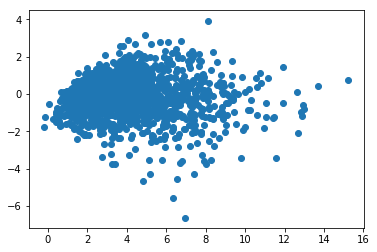

In [358]:
training_predictions = NN_model.predict(X_train)
training = pd.DataFrame(training_predictions)
training['actual'] = y_train.reset_index()['rebounds']
plt.scatter(training_predictions,training[0]-training['actual'])

In [359]:
predictions = NN_model.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

In [360]:
testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['rebounds']
testing['GBR_predictions']=gbr_predictions
testing['LY_rebounding']=X_test['rebounds_ly'].reset_index()['rebounds_ly']

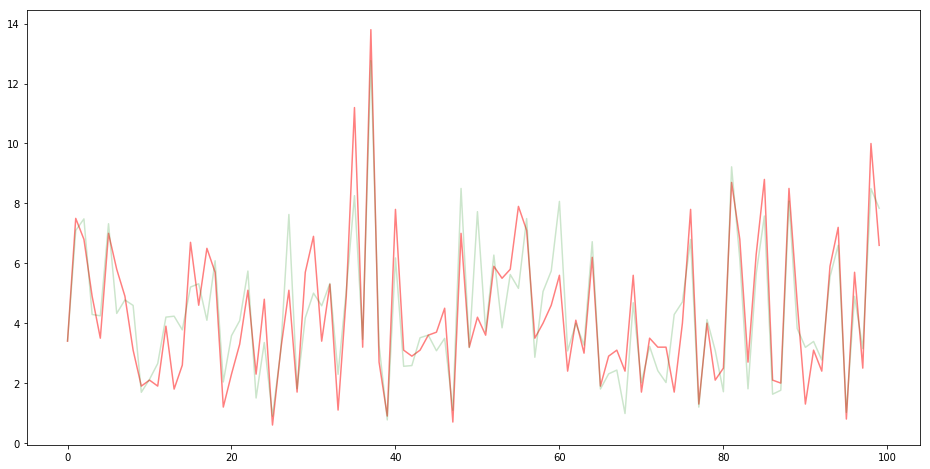

In [361]:
fig,ax = plt.subplots(figsize=(16,8))
plt.plot(testing[0:100].index,testing['actual'][0:100], color = 'r',alpha = 0.5)
plt.plot(testing[0:100].index,testing['NN_predictions'][0:100], color = 'g',alpha = 0.2)
#plt.scatter(testing[0:100].index,testing['LY_rebounding'][0:100],color = 'b',alpha=0.3)

In [362]:
testing.sort_values(by='LY_rebounding',ascending=False)#[50:100]

,NN_predictions,actual,GBR_predictions,LY_rebounding
37,12.765904,13.8,13.489847,14.8
116,11.916736,12.2,10.849303,12.4
530,10.355140,10.3,9.807479,12.1
564,10.638011,10.9,11.094418,12.1
481,10.088206,11.0,11.175805,11.9
441,12.188785,14.1,11.834806,11.8
275,9.861157,12.2,9.963722,11.7
497,10.788072,9.8,10.611417,11.7
439,9.575421,8.7,10.323050,11.5
219,7.563340,4.8,7.630403,11.5


In [367]:
pred_2017rebounds = rebounds[rebounds['season']==2017].drop(['team','player','rebounds','Games'],axis=1)
rebounds_2017 = NN_model.predict(pred_2017rebounds)
test_2 =pd.DataFrame(rebounds_2017)
gbr_reb_2017 = pd.DataFrame(gbr.predict(pred_2017rebounds))
LR_reb_2017 = pd.DataFrame(LR.predict(pred_2017rebounds))
test_3 = pd.merge(rebounds,pred_2017rebounds,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_reb_2017[0]
test_3['LR_pred'] = LR_reb_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','rebounds','rebounds_ly_x','predictions','gbr_pred','LR_pred','mean_pred']].sort_values(by='rebounds_ly_x',ascending=False)[50:100]

,player,rebounds,rebounds_ly_x,predictions,gbr_pred,LR_pred,mean_pred
43,Markieff Morris,5.6,6.5,5.630604,5.717301,5.698308,5.682071
118,Cody Zeller,5.4,6.5,4.502560,4.843199,5.035900,4.793886
14,Dirk Nowitzki,5.7,6.5,5.264424,5.163563,5.804455,5.410814
150,Dewayne Dedmon,7.9,6.5,7.946820,8.934795,7.677720,8.186445
330,Robert Covington,5.4,6.5,5.769932,5.641063,6.119539,5.843512
331,Robin Lopez,4.5,6.4,1.701737,6.060499,6.597710,4.786649
50,Otto Porter,6.4,6.4,5.687191,5.318500,6.085943,5.697212
56,Rudy Gay,5.1,6.3,4.100277,4.241227,4.529746,4.290417
131,Dario Saric,6.7,6.3,7.292883,7.154685,7.273493,7.240354
275,Marc Gasol,8.1,6.3,6.733407,6.389506,6.562646,6.561853


In [ ]:
print('MSE using NN:{}'.format(np.mean((test_3['rebounds']-test_3['predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['rebounds']-np.mean(test_3['rebounds']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['rebounds']-test_3['rebounds_ly_x'])**2)))

In [369]:
print('MSE using NN:{}'.format(np.mean((test_3['rebounds']-test_3['predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['rebounds']-np.mean(test_3['rebounds']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['rebounds']-test_3['rebounds_ly_x'])**2)))
print('MSE using gbr:{}'.format(np.mean((test_3['rebounds']-test_3['gbr_pred'])**2)))
print('MSE using LR:{}'.format(np.mean((test_3['rebounds']-test_3['LR_pred'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['rebounds']-test_3['mean_pred'])**2)))

MSE using NN:1.5360105666030683
MSE using mean:6.292553316074948
MSE using last year stats:1.808012820512822
MSE using gbr:1.3305627955364254
MSE using LR:1.3304784320633838
MSE using combo:1.3020509773938502


In [165]:
cross_val_score(GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5),X_train,y_train,cv=5)

array([0.8111346 , 0.75668588, 0.78079755, 0.72744262, 0.75121757])

In [ ]:
cross_val_score(LinearRegression(),X_train,y_train,cv=5)

In [268]:
'''next is assists'''


query= '''
        
        DROP TABLE IF EXISTS assists_pred;
        CREATE TABLE assists_pred(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        ast float, -- these come from player_stats
        ast_ly float,
        change_ast_ly float,
        Games float,
        C_PF int,
        PG int,
        SG_SF int,
        starter_change int, 
        
        -- these come from team_changes
        high_usageplayer_added int,
        usagemin_opened float,
        maxusage_added float,
        high_usageplayer_dropped int,
        assists_opened float,
        max_assistsdropped float,
        max_assistsadded float,
        points_opened float,
        threes_opened float,
        
        -- from player_advstats
        per_ly float,
        change_per float,
        usagerank float,
        usagerank_ly float,
        ast_perc_ly float,
        change_assist_perc float,
        offensive_winshares float,
        offensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        career_ast float,
        yearspro int
        );
        
        INSERT INTO assists_pred(season,player,age,team,ast,ast_ly,change_ast_ly,starter_change,Games,C_PF,PG,SG_SF)
        SELECT season,player,age,startingteam,ast,ast_ly,change_ast_ly,starter-starter_ly,Games,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end from player_stats;
        
        update assists_pred ap
        set high_usageplayer_added = tc.high_usageplayer_added,usagemin_opened=tc.usagemin_opened,
        maxusage_added=tc.max_usageadded,high_usageplayer_dropped=tc.high_usageplayer_dropped,assists_opened=tc.ast_opened,
        max_assistsdropped=tc.max_astdropped,max_assistsadded=tc.max_astadded,points_opened = tc.points_opened,threes_opened = tc.threes_opened
        from team_changes tc
        where tc.team = ap.team and ap.season=tc.season;
        
        update assists_pred ap
        set per_ly=pa.per_ly,change_per=pa.change_per,usagerank=pa.usagerank,usagerank_ly=pa.usagerank_ly
        ,ast_perc_ly = pa.ast_perc_ly,change_assist_perc = pa.change_assist_perc,offensive_winshares=pa.offensive_winshares,
        offensive_boxplusminus=pa.offensive_boxplusminus,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where ap.player = pa.player and ap.season = pa.season and ap.team = pa.startingteam;
        
        update assists_pred ap
        set career_ast = pc.career_ast, yearspro = pc.yearspro
        from player_careerstats pc
        where ap.player = pc.player and ap.season = pc.season;
        
        
        select * from assists_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
assists_df = pd.DataFrame(np.array(data))
assists_df.columns = ['season','player','age','team','assists','assists_ly','change_assists_ly','Games','C_PF','PG','SG_SF','starter_change','high_usageplayer_added','usagemin_opened','maxusage_added','high_usageplayer_dropped','assists_opened','max_assistsdropped',
                    'max_assistsadded','points_opened','threes_opened','per_ly','change_per','usagerank','usagerank_ly','ast_perc_ly','change_ast_perc','offensive_winshares','offensive_boxplusminus','boxplusminus','value_overreplacement','career_assists','yearspro']

In [247]:
assists_df['age_squared']=assists_df['age']*assists_df['age']
assists = assists_df[assists_df['assists_ly'].notna()]
for i in assists.columns:
    if i not in(['player','team']):
        assists[i]=pd.to_numeric(assists[i])
assists = assists.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [377]:
X = assists[(assists['season']!=2017) & (assists['Games']>30)].drop(['player','team','assists','Games'],axis=1)
y = assists[(assists['season']!=2017) & (assists['Games']>30)]['assists']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [380]:
NN_ast = Sequential()
NN_ast.add(Dense(units=16,input_dim=30,activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_ast.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_ast.add(Dense(units=4, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_ast.add(Dense(units=1,activation='linear'))
NN_ast.compile(loss='mse', optimizer='adam')
NN_ast.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=64)

Epoch 1/1000
1564/1564 [==============================] - 2s 1ms/step - loss: 8352.1222
Epoch 2/1000
1564/1564 [==============================] - 0s 54us/step - loss: 1536.9714
Epoch 3/1000
1564/1564 [==============================] - 0s 52us/step - loss: 730.5720
Epoch 4/1000
1564/1564 [==============================] - 0s 53us/step - loss: 509.0820
Epoch 5/1000
1564/1564 [==============================] - 0s 51us/step - loss: 380.3260
Epoch 6/1000
1564/1564 [==============================] - 0s 54us/step - loss: 295.6683
Epoch 7/1000
1564/1564 [==============================] - 0s 53us/step - loss: 244.8796
Epoch 8/1000
1564/1564 [==============================] - 0s 51us/step - loss: 208.7038
Epoch 9/1000
1564/1564 [==============================] - 0s 50us/step - loss: 180.3206
Epoch 10/1000
1564/1564 [==============================] - 0s 51us/step - loss: 161.4011
Epoch 11/1000
1564/1564 [==============================] - 0s 47us/step - loss: 144.8289
Epoch 12/1000
1564/1564 [====

In [381]:
predictions = NN_ast.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

In [382]:
testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['assists']
testing['GBR_predictions']=gbr_predictions
testing['LY_assists']=X_test['assists_ly'].reset_index()['assists_ly']
testing.sort_values(by='LY_assists',ascending=False)

,NN_predictions,actual,GBR_predictions,LY_assists
167,9.539147,11.7,9.781437,11.2
149,9.129800,10.7,9.656808,10.2
425,9.831399,9.2,10.403659,10.0
462,8.748109,6.5,8.864303,9.8
143,9.449506,9.7,9.692736,9.1
583,8.366265,10.0,8.510544,8.8
469,7.496163,8.0,7.081874,8.3
97,7.738875,5.5,7.433908,8.2
641,6.773023,7.6,7.185693,7.7
201,6.749845,6.6,6.480594,7.6


In [384]:
pred_2017assists = assists[assists['season']==2017].drop(['team','player','assists','Games'],axis=1)
assists_2017 = NN_ast.predict(pred_2017assists)
gbr_ast_2017 = pd.DataFrame(gbr.predict(pred_2017assists))
LR_ast_2017 = pd.DataFrame(LR.predict(pred_2017assists))
test_2 =pd.DataFrame(assists_2017)
test_3 = pd.merge(assists,pred_2017assists,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_ast_2017[0]
test_3['LR_pred'] = LR_ast_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','assists','predictions','assists_ly_x','gbr_pred','LR_pred','mean_pred']].sort_values(by='assists_ly_x',ascending=False)[0:50]

,player,assists,predictions,assists_ly_x,gbr_pred,LR_pred,mean_pred
202,James Harden,8.8,9.181874,11.2,8.797185,9.435171,9.138077
30,John Wall,9.6,9.507752,10.7,9.512599,9.808751,9.609701
335,Russell Westbrook,10.3,10.029798,10.4,9.546243,10.562853,10.046298
116,Chris Paul,7.9,9.120534,9.2,8.761593,8.963949,8.948692
329,Ricky Rubio,5.3,7.820031,9.1,7.772140,8.134931,7.909034
265,LeBron James,9.1,8.205529,8.7,7.994150,8.026597,8.075426
212,Jeff Teague,7.0,5.751962,7.8,6.448696,7.029170,6.409943
237,Jrue Holiday,6.0,4.842092,7.3,6.083935,5.703404,5.543143
257,Kyle Lowry,6.9,6.893334,7.0,7.661846,7.073269,7.209483
156,Draymond Green,7.3,5.819005,7.0,6.191251,6.194833,6.068363


In [386]:
print('MSE using NN:{}'.format(np.mean((test_3['assists']-test_3['predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['assists']-np.mean(test_3['assists']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['assists']-test_3['assists_ly_x'])**2)))
print('MSE using LR:{}'.format(np.mean((test_3['assists']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['assists']-test_3['gbr_pred'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['assists']-test_3['mean_pred'])**2)))

MSE using NN:0.7428029483598435
MSE using mean:3.3617587113740988
MSE using last year stats:0.850384615384615
MSE using LR:0.5360204938681716
MSE using GB:0.5081943911208421
MSE using combo:0.5386291140274688


In [399]:
'''next is steals.  In the future, may want to add minutes from last season?'''


query= '''
        
        DROP TABLE IF EXISTS steals_pred;
        CREATE TABLE steals_pred(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        stl float, -- these come from player_stats
        stl_ly float,
        change_stl_ly float,
        Games float,
        C_PF int,
        PG int,
        SG_SF int,
        starter_change int, 
        

        -- from player_advstats
        per_ly float,
        change_per float,
        stl_perc_ly float,
        change_stl_perc_ly float,
        defensive_winshares float,
        defensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        career_stl float,
        yearspro int
        );
        
        INSERT INTO steals_pred(season,player,age,team,stl,stl_ly,change_stl_ly,starter_change,Games,C_PF,PG,SG_SF)
        SELECT season,player,age,startingteam,stl,stl_ly,change_stl_ly,starter-starter_ly,Games,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end from player_stats;
        
        
        update steals_pred sp
        set per_ly=pa.per_ly,change_per=pa.change_per,stl_perc_ly = pa.stl_perc_ly,change_stl_perc_ly = pa.change_stl_perc_ly
        ,defensive_winshares=pa.defensive_winshares,defensive_boxplusminus=pa.defensive_boxplusminus
        ,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where sp.player = pa.player and sp.season = pa.season and sp.team = pa.startingteam;
        
        update steals_pred sp
        set career_stl = pc.career_stl, yearspro = pc.yearspro
        from player_careerstats pc
        where sp.player = pc.player and sp.season = pc.season;
        
        
        select * from steals_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
steals_df = pd.DataFrame(np.array(data))
steals_df.columns = ['season','player','age','team','steals','steals_ly','change_steals_ly','Games','C_PF','PG','SG_SF','starter_change'
                    ,'per_ly','change_per','stl_perc_ly','change_stl_perc','defensive_winshares','defensive_boxplusminus','boxplusminus','value_overreplacement','career_steals','yearspro']

In [387]:
steals_df['age_squared']=steals_df['age']*steals_df['age']
steals = steals_df[steals_df['steals_ly'].notna()]
for i in steals.columns:
    if i not in(['player','team']):
        steals[i]=pd.to_numeric(steals[i])
steals = steals.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [388]:
X = steals[(steals['season']!=2017) & (steals['Games']>30)].drop(['player','team','steals','Games'],axis=1)
y = steals[(steals['season']!=2017) & (steals['Games']>30)]['steals']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [389]:
NN_stl = Sequential()
NN_stl.add(Dense(units=16,input_dim=19,activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_stl.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_stl.add(Dense(units=4, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_stl.add(Dense(units=1,activation='linear'))
NN_stl.compile(loss='mse', optimizer='adam')
NN_stl.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/1000
1564/1564 [==============================] - 2s 1ms/step - loss: 518214.8728
Epoch 2/1000
1564/1564 [==============================] - 0s 27us/step - loss: 279058.1391
Epoch 3/1000
1564/1564 [==============================] - 0s 26us/step - loss: 139750.0776
Epoch 4/1000
1564/1564 [==============================] - 0s 27us/step - loss: 65175.8204
Epoch 5/1000
1564/1564 [==============================] - 0s 27us/step - loss: 29759.3468
Epoch 6/1000
1564/1564 [==============================] - 0s 26us/step - loss: 15249.9335
Epoch 7/1000
1564/1564 [==============================] - 0s 23us/step - loss: 8344.6012
Epoch 8/1000
1564/1564 [==============================] - 0s 25us/step - loss: 4291.8988
Epoch 9/1000
1564/1564 [==============================] - 0s 24us/step - loss: 1677.7571
Epoch 10/1000
1564/1564 [==============================] - 0s 23us/step - loss: 481.5773
Epoch 11/1000
1564/1564 [==============================] - 0s 25us/step - loss: 245.7537
Epoch 12/1000

In [390]:
predictions = NN_stl.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['steals']
testing['GBR_predictions']=gbr_predictions
testing['LY_steals']=X_test['steals_ly'].reset_index()['steals_ly']
testing.sort_values(by='LY_steals',ascending=False)[50:100]

,NN_predictions,actual,GBR_predictions,LY_steals
172,1.358141,1.3,1.438233,1.5
491,1.397292,1.5,1.491734,1.5
266,1.168331,0.8,1.292477,1.5
597,1.488063,1.6,1.526214,1.5
175,1.477453,1.3,1.526288,1.5
128,1.422665,2.0,1.366565,1.5
243,1.364403,1.6,1.474882,1.5
99,1.326980,1.3,1.395218,1.5
150,1.290931,1.7,1.279994,1.5
433,1.175832,1.2,1.132050,1.5


In [395]:
pred_2017steals = steals[steals['season']==2017].drop(['team','player','steals','Games'],axis=1)
steals_2017 = NN_stl.predict(pred_2017steals)
gbr_stl_2017 = pd.DataFrame(gbr.predict(pred_2017steals))
LR_stl_2017 = pd.DataFrame(LR.predict(pred_2017steals))
test_2 =pd.DataFrame(steals_2017)
test_3 = pd.merge(steals,pred_2017steals,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_stl_2017[0]
test_3['LR_pred'] = LR_stl_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','steals','predictions','LR_pred','gbr_pred','mean_pred','steals_ly_x']].sort_values(by='steals_ly_x',ascending=False)[0:50]


,player,steals,predictions,LR_pred,gbr_pred,mean_pred,steals_ly_x
189,John Wall,1.4,1.679314,1.778605,1.739955,1.732625,2.0
104,Draymond Green,1.4,1.568552,1.566244,1.624291,1.586362,2.0
54,Chris Paul,1.7,1.866328,1.954337,2.036539,1.952401,2.0
178,Jimmy Butler,2.0,1.614456,1.676836,1.750813,1.680702,1.9
317,Robert Covington,1.7,1.448184,1.507417,1.615496,1.523699,1.9
338,Stephen Curry,1.6,1.783131,1.752388,1.838558,1.791359,1.8
361,Trevor Ariza,1.5,1.521492,1.578091,1.603565,1.567716,1.8
340,T.J. McConnell,1.2,1.251057,1.286076,1.510351,1.349161,1.7
316,Ricky Rubio,1.6,1.630803,1.734700,1.811957,1.725820,1.7
324,Russell Westbrook,1.8,1.880314,1.922384,1.616153,1.806284,1.6


In [392]:
print('MSE using LR:{}'.format(np.mean((test_3['steals']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['steals']-test_3['gbr_pred'])**2)))
print('MSE using NN:{}'.format(np.mean((test_3['steals']-test_3['predictions'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['steals']-test_3['mean_pred'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['steals']-np.mean(test_3['steals']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['steals']-test_3['steals_ly_x'])**2)))


MSE using LR:0.05558796722155904
MSE using GB:0.05758201819927772
MSE using NN:0.06117266689151495
MSE using combo:0.05569501924904028
MSE using mean:0.17097129766600938
MSE using last year stats:0.08067307692307688


In [401]:
print(gbr.feature_importances_)
X_train.columns

[0.01125328 0.04008531 0.10639288 0.04426043 0.02392808 0.00408012
 0.0016119  0.0723225  0.04320477 0.05824298 0.0763244  0.08581513
 0.04672878 0.07181035 0.06675481 0.04345141 0.15460267 0.01074619
 0.03838401]


Index(['season', 'age', 'steals_ly', 'change_steals_ly', 'C_PF', 'PG', 'SG_SF',
       'starter_change', 'per_ly', 'change_per', 'stl_perc_ly',
       'change_stl_perc', 'defensive_winshares', 'defensive_boxplusminus',
       'boxplusminus', 'value_overreplacement', 'career_steals', 'yearspro',
       'age_squared'],
      dtype='object')

In [398]:
'''next is blocks.  In the future, may want to add minutes from last season?'''


query= '''
        
        DROP TABLE IF EXISTS blocks_pred;
        CREATE TABLE blocks_pred(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        blk float, -- these come from player_stats
        blk_ly float,
        change_blk_ly float,
        Games float,
        C_PF int,
        PG int,
        SG_SF int,
        starter_change int, 
        

        -- from player_advstats
        per_ly float,
        change_per float,
        blk_perc_ly float,
        change_blk_perc_ly float,
        defensive_winshares float,
        defensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        career_blk float,
        yearspro int
        );
        
        INSERT INTO blocks_pred(season,player,age,team,blk,blk_ly,change_blk_ly,starter_change,Games,C_PF,PG,SG_SF)
        SELECT season,player,age,startingteam,blk,blk_ly,change_blk_ly,starter-starter_ly,Games,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end from player_stats;
        
        
        update blocks_pred bp
        set per_ly=pa.per_ly,change_per=pa.change_per,blk_perc_ly = pa.blk_perc_ly,change_blk_perc_ly = pa.change_blk_perc_ly
        ,defensive_winshares=pa.defensive_winshares,defensive_boxplusminus=pa.defensive_boxplusminus
        ,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where bp.player = pa.player and bp.season = pa.season and bp.team = pa.startingteam;
        
        update blocks_pred bp
        set career_blk = pc.career_blk, yearspro = pc.yearspro
        from player_careerstats pc
        where bp.player = pc.player and bp.season = pc.season;
        
        
        select * from blocks_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
blocks_df = pd.DataFrame(np.array(data))
blocks_df.columns = ['season','player','age','team','blocks','blocks_ly','change_blocks_ly','Games','C_PF','PG','SG_SF','starter_change'
                    ,'per_ly','change_per','blk_perc_ly','change_blk_perc','defensive_winshares','defensive_boxplusminus','boxplusminus','value_overreplacement','career_blocks','yearspro']

In [400]:
blocks_df['age_squared']=blocks_df['age']*blocks_df['age']
blocks = blocks_df[blocks_df['blocks_ly'].notna()]
for i in blocks.columns:
    if i not in(['player','team']):
        blocks[i]=pd.to_numeric(blocks[i])
blocks = blocks.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [441]:
X = blocks[(blocks['season']!=2017) & (blocks['Games']>30)].drop(['player','team','blocks','Games'],axis=1)
#X = blocks[(blocks['season']!=2017) & (blocks['Games']>30)][['blocks_ly','career_blocks','starter_change']]
y = blocks[(blocks['season']!=2017) & (blocks['Games']>30)]['blocks']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [443]:
NN_blk = Sequential()
NN_blk.add(Dense(units=16,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_blk.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_blk.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_blk.add(Dense(units=1,activation='linear'))
NN_blk.compile(loss='mse', optimizer='adam')
NN_blk.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/1000
1564/1564 [==============================] - 2s 1ms/step - loss: 169.0718
Epoch 2/1000
1564/1564 [==============================] - 0s 32us/step - loss: 54.7393
Epoch 3/1000
1564/1564 [==============================] - 0s 30us/step - loss: 40.0995
Epoch 4/1000
1564/1564 [==============================] - 0s 39us/step - loss: 32.4636
Epoch 5/1000
1564/1564 [==============================] - 0s 31us/step - loss: 27.7551
Epoch 6/1000
1564/1564 [==============================] - 0s 31us/step - loss: 23.8176
Epoch 7/1000
1564/1564 [==============================] - 0s 30us/step - loss: 21.0157
Epoch 8/1000
1564/1564 [==============================] - 0s 32us/step - loss: 17.1252
Epoch 9/1000
1564/1564 [==============================] - 0s 31us/step - loss: 15.2152
Epoch 10/1000
1564/1564 [==============================] - 0s 30us/step - loss: 11.8473
Epoch 11/1000
1564/1564 [==============================] - 0s 32us/step - loss: 9.2615
Epoch 12/1000
1564/1564 [=================

In [444]:
predictions = NN_blk.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = None,max_features=0.3)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['blocks']
testing['GBR_predictions']=gbr_predictions
testing['LY_blocks']=X_test['blocks_ly'].reset_index()['blocks_ly']
testing.sort_values(by='LY_blocks',ascending=False)[50:100]

,NN_predictions,actual,GBR_predictions,LY_blocks
128,1.473373,1.3,1.239849,1.3
327,1.381236,0.8,1.099172,1.3
244,1.429256,0.2,1.263199,1.3
460,1.277068,1.1,1.039512,1.3
656,1.370475,0.7,0.934486,1.3
419,1.517829,1.5,1.099204,1.2
630,1.576911,1.1,1.047491,1.2
72,1.441978,1.2,1.108170,1.2
423,1.303337,1.6,1.072781,1.2
489,1.313171,0.7,1.076979,1.2


In [445]:
pred_2017blocks = blocks[blocks['season']==2017].drop(['team','player','blocks','Games'],axis=1)
#pred_2017blocks = blocks[blocks['season']==2017][['blocks_ly','career_blocks','starter_change']]
blocks_2017 = NN_blk.predict(pred_2017blocks)
gbr_blk_2017 = pd.DataFrame(gbr.predict(pred_2017blocks))
LR_blk_2017 = pd.DataFrame(LR.predict(pred_2017blocks))
test_2 =pd.DataFrame(blocks_2017)
test_3 = pd.merge(blocks,pred_2017blocks,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_blk_2017[0]
test_3['LR_pred'] = LR_blk_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','blocks','predictions','LR_pred','gbr_pred','mean_pred','blocks_ly_x']].sort_values(by='blocks_ly_x',ascending=False)[0:50]


,player,blocks,predictions,LR_pred,gbr_pred,mean_pred,blocks_ly_x
323,Rudy Gobert,2.3,2.384002,2.164193,2.136520,2.228238,2.6
186,Joel Embiid,1.8,2.456306,2.210025,2.248079,2.304804,2.5
21,Anthony Davis,2.6,2.267372,1.982206,2.241989,2.163855,2.2
275,Myles Turner,1.8,2.080682,1.831949,1.746683,1.886438,2.1
134,Hassan Whiteside,1.7,2.161163,2.014637,1.580400,1.918734,2.1
226,Kristaps Porzingis,2.4,1.990268,1.763285,1.493095,1.748883,2.0
127,Giannis Antetokounmpo,1.4,1.774188,1.581997,1.547266,1.634484,1.9
40,Brook Lopez,1.3,1.705501,1.432882,1.523154,1.553846,1.7
78,DeAndre Jordan,0.9,1.798225,1.542816,1.329975,1.557005,1.7
219,Kevin Durant,1.8,1.505576,1.253495,1.357542,1.372205,1.6


In [446]:
print('MSE using LR:{}'.format(np.mean((test_3['blocks']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['blocks']-test_3['gbr_pred'])**2)))
print('MSE using NN:{}'.format(np.mean((test_3['blocks']-test_3['predictions'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['blocks']-test_3['mean_pred'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['blocks']-np.mean(test_3['blocks']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['blocks']-test_3['blocks_ly_x'])**2)))


MSE using LR:0.03722589949460395
MSE using GB:0.04058784592984654
MSE using NN:0.12255816610021561
MSE using combo:0.04392197487777133
MSE using mean:0.18036817882971726
MSE using last year stats:0.04798076923076909


In [ ]:
 query= '''
        
        DROP TABLE IF EXISTS threes_pred;
        CREATE TABLE threes_pred(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        threes_made float, -- these come from player_stats
        threes_ly float,
        change_threes float
        points_ly float,
        change_points_ly float,
        starter_change int,
        C_PF int,
        PG int,
        SG_SF int,
        
         -- these come from team_changes
        high_usageplayer_added int,
        usagemin_opened float,
        maxusage_added float,
        high_usageplayer_dropped int,
        points_opened float,
        max_pointsdropped float,
        max_pointsadded float,
        
        three_ar_ly float, -- from player_advstats
        change_3ar float,
        per_ly float,
        change_per float,
        usagerank float,
        usagerank_ly float,
        offensive_winshares float,
        offensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        career_threes float,
        yearspro int
        );
        
        INSERT INTO threes_pred(season,player,age,team,threes_made,threes_ly,change_threes,points_ly,change_points_ly,starter_change,C_PF,PG,SG_SF)
        SELECT season,player,age,startingteam,threes_made,threes_ly,change_threes,points_ly,change_points_ly,starter-starter_ly,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end from player_stats;
        
        update threes_pred tp
        set high_usageplayer_added = tc.high_usageplayer_added,usagemin_opened=tc.usagemin_opened,
        maxusage_added=tc.max_usageadded,high_usageplayer_dropped=tc.high_usageplayer_dropped,points_opened=tc.points_opened,
        max_pointsdropped=tc.max_pointsdropped,max_pointsadded=tc.max_pointsadded
        from team_changes tc
        where tc.team = tp.team and tp.season=tc.season;
        
        update threes_pred tp
        set three_ar_ly = pa.threear_ly,change_3ar=pa.change_3ar,per_ly=pa.per_ly,change_per=pa.change_per,
        usagerank=pa.usagerank,usagerank_ly=pa.usagerank_ly,offensive_winshares=pa.offensive_winshares,
        offensive_boxplusminus=pa.offensive_boxplusminus,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where tp.player = pa.player and tp.season = pa.season and tp.team = pa.startingteam;
        
        update threes_pred pp
        set career_threes = pc.career_threes, yearspro = pc.yearspro
        from player_careerstats pc
        where tp.player = pc.player and tp.season = pc.season;
        
        
        select * from threes_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
points_df = pd.DataFrame(np.array(data))
points_df.columns = ['season','player','age','team','points','points_ly','change_points_ly','starter_change','C_PF','PG','SG_SF','high_usageplayer_added','usagemin_opened','maxusage_added','high_usageplayer_dropped','points_opened','max_pointsdropped',
                    'max_pointsadded','three_ar_ly','change_3ar','per_ly','change_per','usagerank','usagerank_ly','offensive_winshares','offensive_boxplusminus','boxplusminus','value_overreplacement','career_points','yearspro']